In [4]:
import sys
import os
# Añadir el directorio 'functions' al sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'functions')))
import functions as mf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import optuna
import pickle

import warnings
warnings.filterwarnings("ignore")

# Carga de datos

## Constantes globales

In [5]:
# Construir la ruta relativa hacia la carpeta de los datos crudos
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "trade_prices")

# Ruta hacia la carpeta de datos procesados
PROCESSED_DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")


# Ruta hacia la carpeta de modelos
MODEL_PATH = os.path.join(os.path.dirname(os.getcwd()), "models")

# Nombre del archivo Parquet
PARQUET_FILE_NAME = "merged_trade_prices.parquet"


## Funciones de carga

In [6]:
# mf.process_and_save_csv_to_parquet()

In [7]:
df = mf.load_parquet_to_dataframe()


Shape of the DataFrame: (3906518, 37)
                           Type            Region  MunicipalityCode  \
0   Residential Land(Land Only)  Residential Area              1101   
1   Residential Land(Land Only)  Residential Area              1101   
2  Pre-owned Condominiums, etc.              None              1101   
3   Residential Land(Land Only)  Residential Area              1101   
4   Residential Land(Land Only)  Residential Area              1101   

  Prefecture            Municipality DistrictName NearestStation  \
0   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
1   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
2   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
3   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
4   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   

  TimeToNearestStation  MinTimeToNearestStation  MaxTimeToNearestStation  ...  \
0                   28                     28

# Exploración inicial

In [8]:
# Mostrar las 5 primeras filas del dataframe
df.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28.0,28.0,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,None,None
1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27.0,27.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,None,None
2,"Pre-owned Condominiums, etc.",None,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20.0,20.0,...,None,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,None
3,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26.0,26.0,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,None,None
4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23.0,23.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,None,None


In [9]:
# Información general del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906518 entries, 0 to 3906517
Data columns (total 37 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Type                         object 
 1   Region                       object 
 2   MunicipalityCode             int64  
 3   Prefecture                   object 
 4   Municipality                 object 
 5   DistrictName                 object 
 6   NearestStation               object 
 7   TimeToNearestStation         object 
 8   MinTimeToNearestStation      float64
 9   MaxTimeToNearestStation      float64
 10  TradePrice                   int64  
 11  FloorPlan                    object 
 12  Area                         int64  
 13  AreaIsGreaterFlag            int64  
 14  UnitPrice                    float64
 15  PricePerTsubo                float64
 16  LandShape                    object 
 17  Frontage                     float64
 18  FrontageIsGreaterFlag        bool   
 19  

In [10]:
# Información estadística del dataframe
df.describe()

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,Frontage,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
count,3.906518e+06,3.315977e+06,3.228071e+06,3.906518e+06,3.906518e+06,3.906518e+06,1.384415e+06,1.384415e+06,2.537063e+06,1.317660e+06,3.906518e+06,1.869804e+06,3.906518e+06,2.685837e+06,3.191877e+06,3.191877e+06,3.906518e+06,3.906518e+06
mean,2.046713e+04,2.258420e+01,2.738394e+01,2.760589e+07,4.674023e+02,3.749528e-02,8.514886e+04,2.814065e+05,1.463955e+01,1.751561e+02,2.924343e-03,1.995469e+03,9.860443e-04,6.792815e+00,6.101047e+01,2.089891e+02,2.012866e+03,2.519816e+00
std,1.217548e+04,2.308245e+01,2.773212e+01,1.417460e+08,8.476877e+02,1.899721e-01,1.686832e+05,5.570316e+05,9.828225e+00,2.564390e+02,5.399808e-02,1.522054e+01,3.138586e-02,4.634588e+00,1.002819e+01,1.075456e+02,3.678827e+00,1.118905e+00
min,1.101000e+03,0.000000e+00,0.000000e+00,1.000000e+02,1.000000e+01,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e-01,1.000000e+01,0.000000e+00,1.945000e+03,0.000000e+00,1.000000e+00,3.000000e+01,5.000000e+01,2.005000e+03,1.000000e+00
25%,1.220400e+04,9.000000e+00,8.000000e+00,5.000000e+06,1.000000e+02,0.000000e+00,1.600000e+04,5.500000e+04,8.500000e+00,9.500000e+01,0.000000e+00,1.984000e+03,0.000000e+00,4.000000e+00,6.000000e+01,2.000000e+02,2.010000e+03,2.000000e+00
50%,1.721000e+04,1.600000e+01,1.500000e+01,1.400000e+07,1.850000e+02,0.000000e+00,4.000000e+04,1.300000e+05,1.200000e+01,1.050000e+02,0.000000e+00,1.996000e+03,0.000000e+00,6.000000e+00,6.000000e+01,2.000000e+02,2.013000e+03,3.000000e+00
75%,2.811000e+04,3.000000e+01,2.900000e+01,2.900000e+07,3.700000e+02,0.000000e+00,9.100000e+04,3.000000e+05,1.700000e+01,1.400000e+02,0.000000e+00,2.009000e+03,0.000000e+00,7.000000e+00,6.000000e+01,2.000000e+02,2.016000e+03,4.000000e+00
max,4.738200e+04,1.200000e+02,1.200000e+02,6.100000e+10,5.000000e+03,1.000000e+00,2.000000e+07,6.600000e+07,5.000000e+01,2.000000e+03,1.000000e+00,2.020000e+03,1.000000e+00,9.990000e+01,8.000000e+01,1.300000e+03,2.019000e+03,4.000000e+00


Ahora haremos una revisión de qué porcentaje de valores nulos contiene cada campo del dataframe.

In [11]:
# Contar el porcentaje de valores nulos en las columnas
(df.isnull().sum()/df.shape[0])*100

Type                            0.000000
Region                         28.595209
MunicipalityCode                0.000000
Prefecture                      0.000000
Municipality                    0.000000
DistrictName                    0.211825
NearestStation                 14.483768
TimeToNearestStation           15.116812
MinTimeToNearestStation        15.116812
MaxTimeToNearestStation        17.367052
TradePrice                      0.000000
FloorPlan                      84.713497
Area                            0.000000
AreaIsGreaterFlag               0.000000
UnitPrice                      64.561407
PricePerTsubo                  64.561407
LandShape                      28.862788
Frontage                       35.055643
FrontageIsGreaterFlag           0.000000
TotalFloorArea                 66.270218
TotalFloorAreaIsGreaterFlag     0.000000
BuildingYear                   52.136301
PrewarBuilding                  0.000000
Structure                      51.041490
Use             

Como podemos observar, el campo TradePrice no contiene valores nulos por lo que podemos utilizarlo para nuestro estudio sin tener que imputar valores o eliminar filas.

In [12]:

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("\nColumnas categóricas detectadas:")
print(categorical_columns.tolist())


Columnas categóricas detectadas:
['Type', 'Region', 'Prefecture', 'Municipality', 'DistrictName', 'NearestStation', 'TimeToNearestStation', 'FloorPlan', 'LandShape', 'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'CityPlanning', 'Period', 'Renovation', 'Remarks']


In [13]:
# Eliminamos las columnas 'TimeToNearestStation' y 'Remarks'
df.drop(columns=['TimeToNearestStation', 'Remarks'], inplace=True)

# Eliminar 'TimeToNearestStation' y 'Remarks' de la lista categorical_columns
categorical_columns = [elemento for elemento in categorical_columns if elemento not in ['TimeToNearestStation', 'Remarks']]



Identificamos duplicados, los guardamos y los eliminamos del DataFrame original.

In [14]:
# Identificar duplicados
duplicados = df[df.duplicated()]

# Guardar los duplicados en un nuevo DataFrame
duplicados_df = duplicados.copy()

# Eliminar duplicados
initial_shape = df.shape
df = df.drop_duplicates()
final_shape = df.shape
print("----------------------------")
print(f"Registros eliminados: {initial_shape[0] - final_shape[0]}")


----------------------------
Registros eliminados: 19550


# Análisis de tendencia de precios

In [15]:
# Tipos de propiedades
df['Type'].unique()

array(['Residential Land(Land Only)', 'Pre-owned Condominiums, etc.',
       'Residential Land(Land and Building)', 'Forest Land',
       'Agricultural Land'], dtype=object)

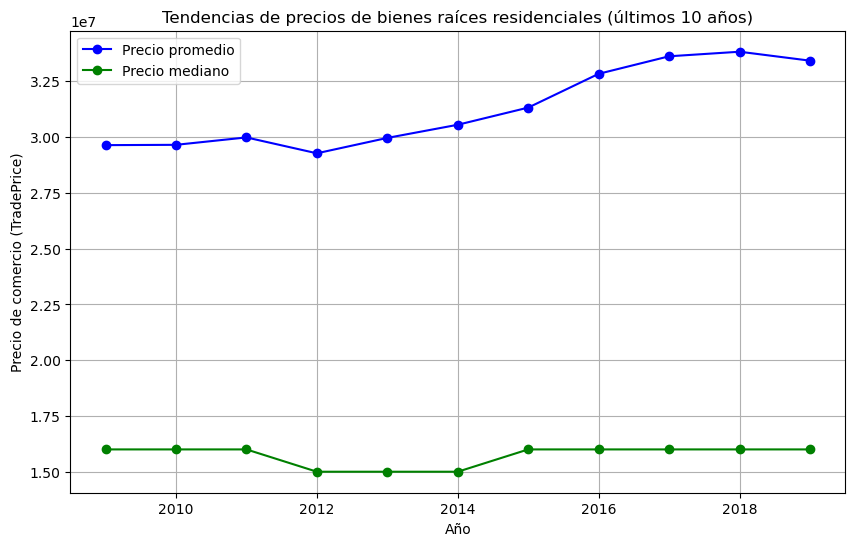

In [16]:
  
mf.analyze_price_trends(df)

## Análisis del Gráfico de Tendencias de Precios de Bienes Raíces Residenciales de Japón en los últimos 10 años

El gráfico muestra la evolución de los precios promedio (media) y medianos de bienes raíces residenciales durante los últimos de 10 años. La línea del precio promedio muestra una tendencia general al alza, lo que indica un crecimiento sostenido en los valores de las propiedades a lo largo del tiempo, mientras que el precio mediano indica un valor sostenido excepto en el período 2012-2014 en el cual el decrece.

#### Tendencia general:

Precio promedio: Muestra un crecimiento constante y acelerado a partir de 2014, alcanzando su punto máximo alrededor de 2018. Luego, experimenta una ligera disminución.
Precio mediano: Presenta un comportamiento más estable hasta 2011, momento en el que inicia un descenso hasta el año 2015, año en el cual vuelve a niveles del año 2011 y a partir de allí se manteniene estable.

Diferencia entre Media y Mediana:
La distancia entre ambas líneas puede indicar la presencia de valores atípicos o una distribución de precios sesgada. En este caso, la brecha creciente sugiere que la distribución de precios se está volviendo más asimétrica, posiblemente debido a un aumento en el número de propiedades de muy alto valor que están elevando el promedio.

#### Puntos clave:

2012: Se observa una ligera caída en ambos indicadores, lo que podría corresponder a un período de desaceleración económica o cambios en las políticas del mercado inmobiliario.
2014-2018: Es el período de mayor crecimiento, con un aumento significativo en ambos indicadores. Esto sugiere un mercado inmobiliario dinámico y con alta demanda.
Post 2018: Se aprecia una estabilización o ligera disminución en el precio promedio, mientras que el mediano se mantiene relativamente constante. Esto podría indicar una saturación del mercado o cambios en las preferencias de los compradores.

### Conclusiones preliminares:

El análisis del gráfico sugiere que el mercado inmobiliario residencial ha experimentado un crecimiento sostenido en los últimos 10 años. Sin embargo, la dinámica del mercado parece estar cambiando, con una posible desaceleración o estabilización en los últimos años.

# Análisis Comparativo: Tokyo vs. Otras Regiones

Métricas para Tokyo:
                    mean      median
TradePrice  6.592217e+07  35000000.0
UnitPrice   4.245079e+05    340000.0

Métricas para otras regiones:
                    mean      median
TradePrice  2.324817e+07  12000000.0
UnitPrice   6.450218e+04     37000.0


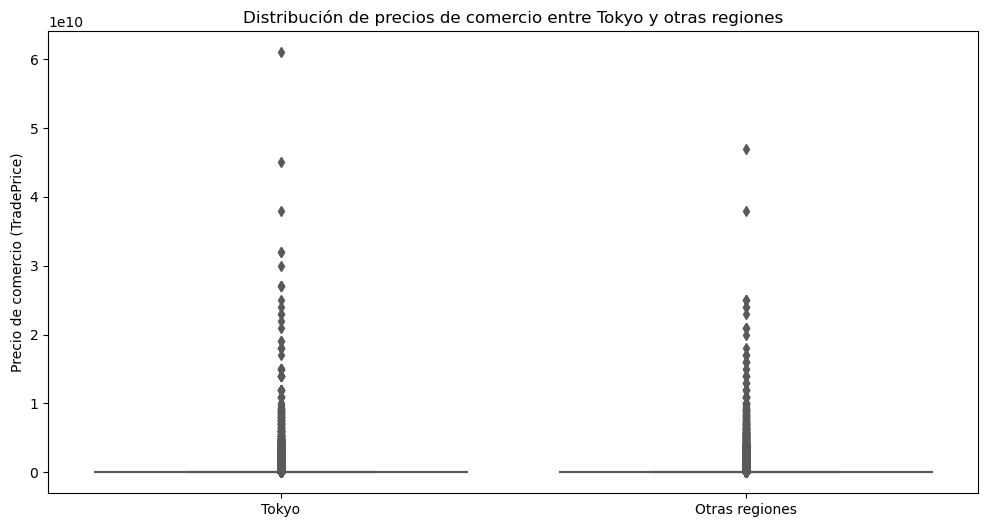

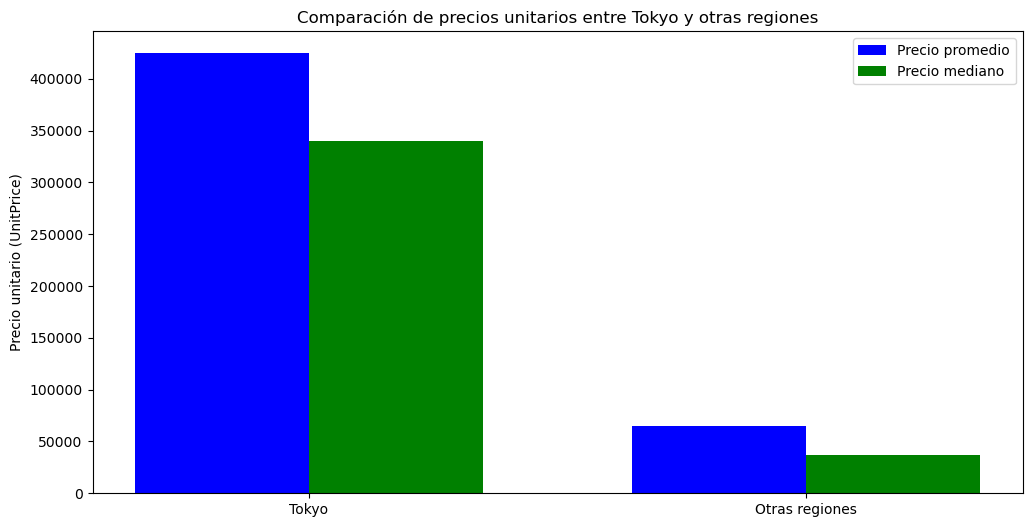

In [17]:
mf.compare_tokyo_vs_others(df)

En el gráfico de barras se puede observar que los valores extremadamente altos afectan a la visualización, debido a outliers. Esto puede ser ajustado aplicando una limpieza para excluir valores atípicos que distorsionan el análisis.

## Manejo de Outliers

Podemos filtrar los datos para excluir outliers en la columna TradePrice. Una forma común es utilizar los rangos intercuartílicos (IQR) para eliminar valores fuera de un rango razonable.

lower_bound = Q1 - 1.5 * IQR

upper_bound = Q3 + 1.5 * IQR

Métricas para Tokyo (sin outliers):
                    mean      median
TradePrice  3.587199e+07  33000000.0
UnitPrice   3.591345e+05    310000.0

Métricas para otras regiones (sin outliers):
                    mean      median
TradePrice  1.484684e+07  11000000.0
UnitPrice   5.686607e+04     35000.0


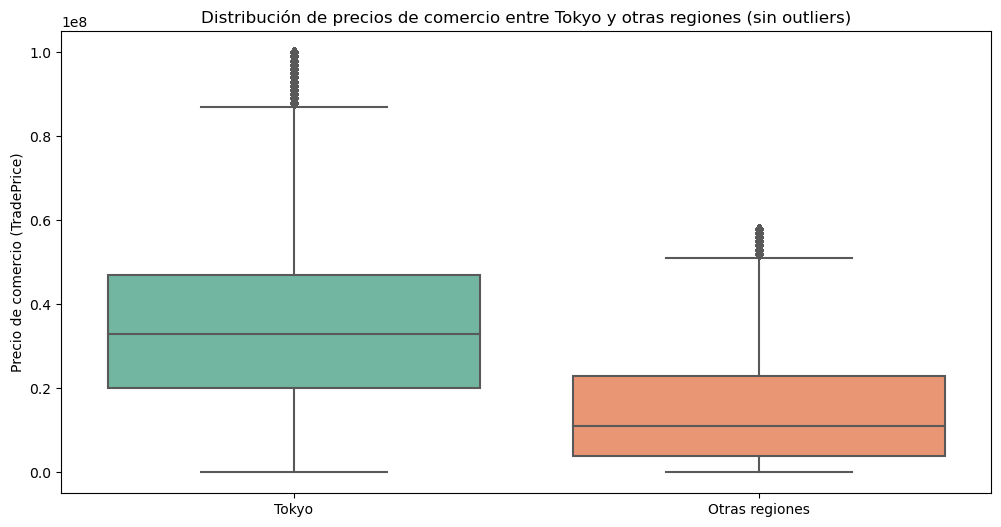

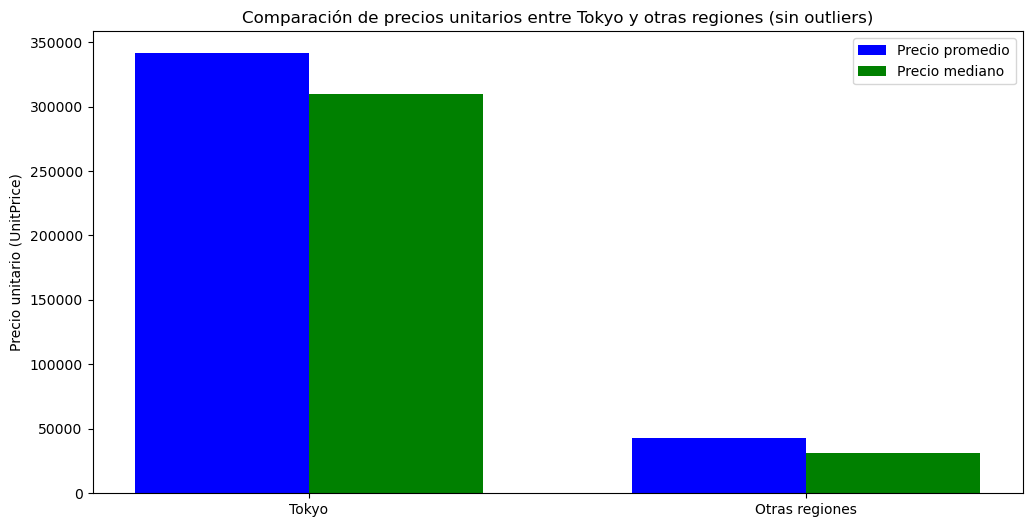

In [18]:
mf.compare_tokyo_vs_others_with_outlier_removal(df)

### Descripción General y Tendencias

#### Tokyo
- **Valores más altos**:  
  La media y la mediana indican que Tokyo tiene precios significativamente más altos que otras regiones, tanto en comercio total como en precio unitario. Esto podría deberse a factores como:  
  - Mayor demanda.  
  - Productos de mayor calidad o categoría.  
  - Costos de operación más elevados (alquiler, transporte, etc.).  

- **Rango intercuartil amplio**:  
  Sugiere que, incluso sin los outliers, los precios varían considerablemente dentro de Tokyo, reflejando un mercado diverso con una mezcla de productos de gama baja y alta.

#### Otras Regiones
- **Precios más bajos**:  
  Las métricas (media y mediana) son significativamente menores, lo cual indica un mercado menos sofisticado o con menor demanda.  

- **Distribución más homogénea**:  
  El rango intercuartil es más compacto, lo que apunta a una menor variabilidad en los precios. Esto puede implicar menos diferenciación de productos o estandarización en las transacciones.



### Comparación Relativa entre Tokyo y Otras Regiones

- **Relación entre las medias**:  
  - Tokyo tiene un precio de comercio promedio **2.4 veces mayor** que otras regiones (35.8M vs. 14.8M).  
  - En términos de precio unitario, Tokyo tiene precios promedio **6.3 veces mayores** que otras regiones (359k vs. 56k).  

- **Evidencia**:  
  Tokyo no solo tiene transacciones más costosas en términos absolutos, sino también productos con precios significativamente más altos por unidad.  

- **Posibles explicaciones**:  
  - Tokyo puede representar un mercado premium donde se comercian productos de lujo o servicios exclusivos.  
  - Las otras regiones probablemente operen en mercados más enfocados en volumen o con menor poder adquisitivo.



### Observaciones de la Gráfica

- **Distribución de precios (Boxplot)**:  
  - **En Tokyo**:  
    Los datos se distribuyen en un rango mucho más amplio, con precios de comercio que oscilan entre 20M y 60M en el rango intercuartil. Esto muestra que existe una mayor diversidad de transacciones (productos o servicios de diferentes categorías económicas).  
  - **En otras regiones**:  
    La concentración de los datos sugiere una menor diversificación, con transacciones mayoritariamente concentradas en un rango más bajo.  

- **Outliers**:  
  Aunque eliminados en esta gráfica, la cantidad de outliers en Tokyo podría reflejar transacciones inusualmente grandes, probablemente por bienes raíces, tecnología o mercados financieros.



### Relación Entre Precios de Comercio y Unitarios

- Tokyo no solo tiene precios de comercio más altos, sino que también los precios unitarios son notablemente mayores.  
- **Implicaciones**:  
  - Tokyo genera la mayor parte del volumen comercial con productos o servicios costosos.  
  - En otras regiones, el comercio parece depender de la venta de mayor cantidad de unidades a precios mucho más bajos.



Métricas para Tokyo:
            mean  median
Area  117.801574    75.0

Métricas para otras regiones:
            mean  median
Area  505.662741   200.0


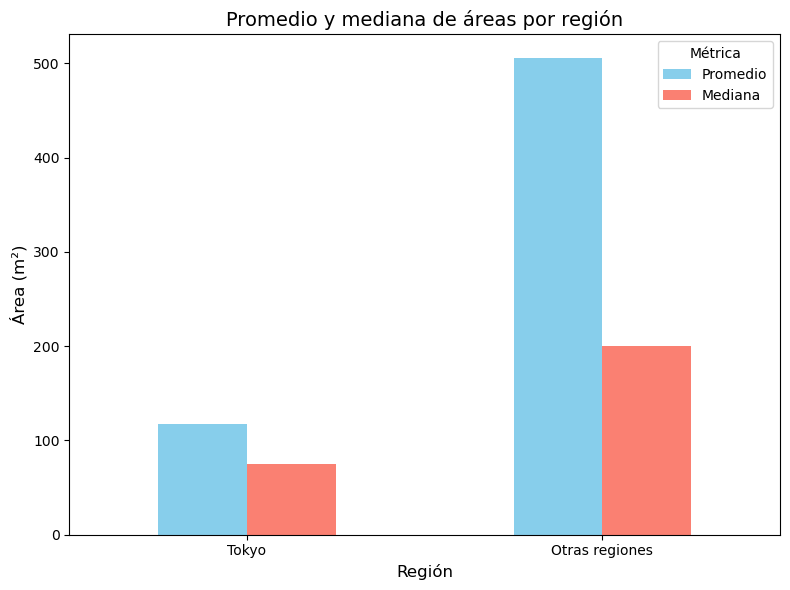

In [19]:
mf.graficar_promedio_mediana_areas(df)

#### 1. Diferencia en promedio y mediana
- **Tokyo**:  
  - Área promedio: **117.8 m²**  
  - Mediana: **75 m²**  
  Esto indica que, aunque existen algunas propiedades grandes, la mayoría son más pequeñas, como lo refleja la mediana significativamente menor que el promedio.

- **Otras regiones**:  
  - Área promedio: **505.67 m²**  
  - Mediana: **200 m²**  
  Las propiedades en otras regiones son, en promedio, considerablemente más grandes, y la mediana mayor refuerza la idea de un menor nivel de compactación en comparación con Tokyo.



#### 2. Interpretación de las métricas
- **Tokyo**:  
  - Las áreas pequeñas predominan, lo que es típico de grandes ciudades con alta densidad de población y espacio limitado.  
  - La discrepancia entre el promedio y la mediana sugiere la presencia de algunas propiedades excepcionalmente grandes que elevan el promedio.

- **Otras regiones**:  
  - Las propiedades más grandes son comunes, reflejando espacios más amplios disponibles y un costo de espacio probablemente menor.  
  - Esto contrasta con el mercado compacto de Tokyo.



#### 3. Conclusión sobre el comercio
- Tokyo muestra una tendencia hacia propiedades más pequeñas, un reflejo de las limitaciones de espacio de una megaciudad con alta densidad poblacional.  
- Este mercado probablemente está más orientado hacia propiedades funcionales y optimizadas, con altos costos por metro cuadrado.  
- En cambio, las otras regiones presentan un enfoque más predominante en propiedades más grandes y expansivas, debido a menores restricciones de espacio.



#### Conclusión final
La comparación de las áreas promedio y medianas refuerza la idea de que Tokyo tiene un mercado inmobiliario significativamente diferente al de las otras regiones.  
- **Tokyo**: El comercio refleja la alta demanda por propiedades compactas, influenciado por los altos costos y las limitaciones de espacio.  
- **Otras regiones**: Predominan propiedades más grandes, con mayor disponibilidad de espacio, lo que las hace aptas para un enfoque comercial distinto.  
En general, estos factores influyen en el tipo de comercio y servicios que prosperan en cada región.


# Predicción de precio del inmueble

Lo primero que haremos es tomar una muestra de la población para reducir el tiempo de ejecución de graficado y del estudio de los modelos de Machine Learning. Realizaremos el test de Kolmogorov-Smirnov (KS) para evaluar si la muestra es representativa de la población original.

In [20]:
ks_results, df_muestra, conclusion = mf.tomar_muestra_y_comparar(df, 10)  

# Mostrar los resultados
print(f"Resultados KS por columna:\n{ks_results}")
print(f"\nConclusión: {conclusion}")

Resultados KS por columna:
{'MunicipalityCode': (0.0014923119496024206, 0.41040121430182164), 'MinTimeToNearestStation': (0.14996295305328589, 0.0), 'MaxTimeToNearestStation': (0.17283944264926832, 0.0), 'TradePrice': (0.0010596422405001749, 0.8219908452145545), 'Area': (0.0010565085479403158, 0.8247265572839975), 'AreaIsGreaterFlag': (0.0003255238637902558, 0.9999999999999302), 'UnitPrice': (0.644742935353078, 0.0), 'PricePerTsubo': (0.644742935353078, 0.0), 'Frontage': (0.3481281001090827, 0.0), 'TotalFloorArea': (0.6616404593821392, 0.0), 'TotalFloorAreaIsGreaterFlag': (4.8360801226499106e-05, 1.0), 'BuildingYear': (0.5211321958548583, 0.0), 'PrewarBuilding': (4.785026970144379e-05, 1.0), 'Breadth': (0.31090251809650327, 0.0), 'CoverageRatio': (0.18233529544940008, 0.0), 'FloorAreaRatio': (0.18233635364635847, 0.0), 'Year': (0.001763502925931637, 0.22151777610134105), 'Quarter': (0.0008584976381255105, 0.956753031169949)}

Conclusión: La muestra no es representativa de la población.

Como podemos observar por los resultados, la muestra no es representativa. Esto puede ser debido a que los datos son muy dispersos o presenta muchos valores extremos (como pudimos observar en gráficos anteriores) o presencia importante de valores nulos (en algunas columnas también se observaron altos porcentajes de estos valores).

# Preprocesamiento de los datos

## Encoding


### Decisiones sobre Encoding de Variables Categóricas

#### Razón para elegir Label Encoding
- Los campos categóricos son de tipo nominal (sin un orden inherente entre las categorías).
- El uso de One-Hot Encoding podría generar un dataset extremadamente grande debido a la alta cardinalidad de las columnas `Prefecture`, `Municipality` y `DistrictName`, lo que complicaría el almacenamiento y la computación.
- A efectos prácticos, utilizamos **Label Encoding**, que asigna un número único a cada categoría en lugar de expandirlas en múltiples columnas.

#### Eliminación de la columna `MunicipalityCode`
- Esta columna no contiene información relevante para el análisis (es redundante con `Municipality` y podría introducir ruido en los datos).

#### Estrategias futuras para mejorar la performance del modelo
En un análisis más exhaustivo, podrían explorarse las siguientes técnicas:
- **Agrupar categorías menos frecuentes en una categoría "Otros":** Esto ayuda a reducir la dimensionalidad manteniendo la información más representativa.
- **Target Encoding:** Sustituir cada categoría por la media de la variable objetivo asociada a ella. Es útil si hay una relación clara entre la categoría y la variable objetivo.
- **One-Hot Encoding:** Es el enfoque más completo para variables categóricas, pero requiere cuidado con la cardinalidad.
- **Feature Hashing:** Una técnica eficiente para manejar variables con alta cardinalidad, mapeándolas a un espacio de características más pequeño.



In [21]:
# Eliminamos las columnas 'TimeToNearestStation' y 'Remarks'
df_to_encode = df_muestra.drop(columns='MunicipalityCode')

# Eliminar 'TimeToNearestStation' y 'Remarks' de la lista categorical_columns
categorical_columns_to_encode = [elemento for elemento in categorical_columns if elemento not in ['MunicipalityCode']]

In [22]:
# Aplicar Label Encoding
df_label = mf.encode_categorical_columns(df_to_encode, categorical_columns_to_encode, encoding_type="label")

df_label.head()

,Type,Region,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,...,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation
3603983,4,0,6,470,20575,526,3.0,3.0,17000000,36,...,3,2,12.0,6,80.0,400.0,29,2006,3,1
1140137,2,2,40,1530,1310,3432,4.0,4.0,47000000,5,...,2,7,NaN,6,80.0,600.0,11,2017,1,2
3166167,0,2,36,823,47240,4868,NaN,NaN,2700000,36,...,2,7,NaN,11,NaN,NaN,20,2012,2,1
976578,3,4,3,1753,37120,6950,30.0,60.0,6400000,36,...,8,2,5.0,2,60.0,150.0,21,2013,2,1
59149,2,2,11,701,9445,868,30.0,60.0,13000000,23,...,2,7,NaN,14,60.0,200.0,8,2014,1,0


### Pruebas de funcionamiento con Random Forest y reajuste del DataFrame

In [23]:
# Separar las variables independientes (X) y dependiente (y)
X = df_label.drop(columns=['TradePrice'])
y = df_label['TradePrice']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputar valores faltantes en X_train y X_test
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [24]:
# Entrenar un modelo Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Obtener e imprimir la importancia de las características

                        Feature  Importance
9                          Area    0.102012
16               TotalFloorArea    0.099204
5                NearestStation    0.090634
12                PricePerTsubo    0.056958
10            AreaIsGreaterFlag    0.055496
18                 BuildingYear    0.050167
29                       Period    0.048940
11                    UnitPrice    0.046485
14                     Frontage    0.043147
28               FloorAreaRatio    0.042949
25                      Breadth    0.040949
24               Classification    0.039366
4                  DistrictName    0.038549
30                         Year    0.027447
6       MinTimeToNearestStation    0.025304
2                    Prefecture    0.024692
21                          Use    0.022868
7       MaxTimeToNearestStation    0.021703
3                  Municipality    0.021571
23                    Direction    0.018204
13                    LandShape    0.017270
26                 CityPlanning 

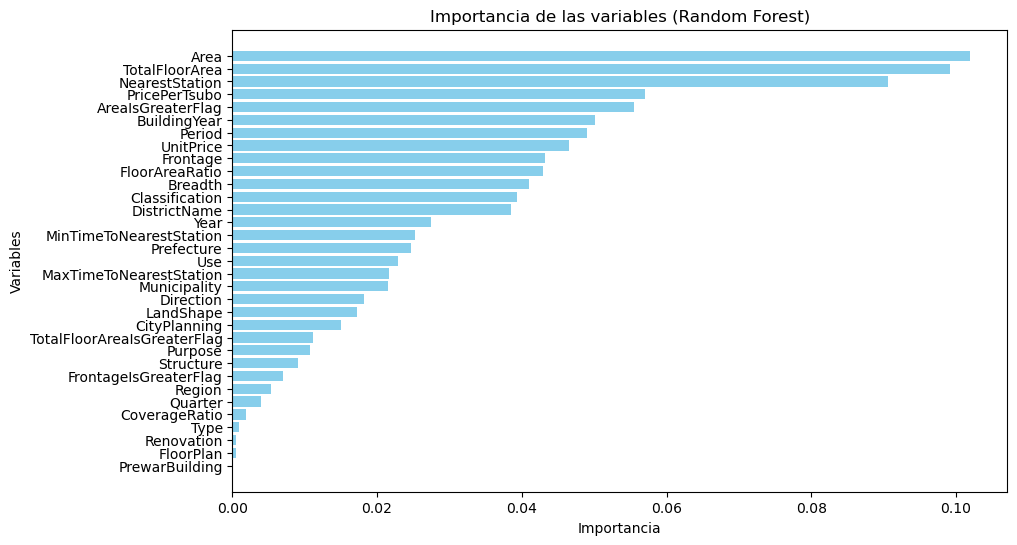

In [25]:
mf.mostrar_importancia_variables(rf_model, X)

In [26]:
# Mostramos algunas métricas del modelo
y_pred = rf_model.predict(X_test)

print("Modelo original:")
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

Modelo original:
RMSE: 93321645.26937456
R²: 0.4505078629401995


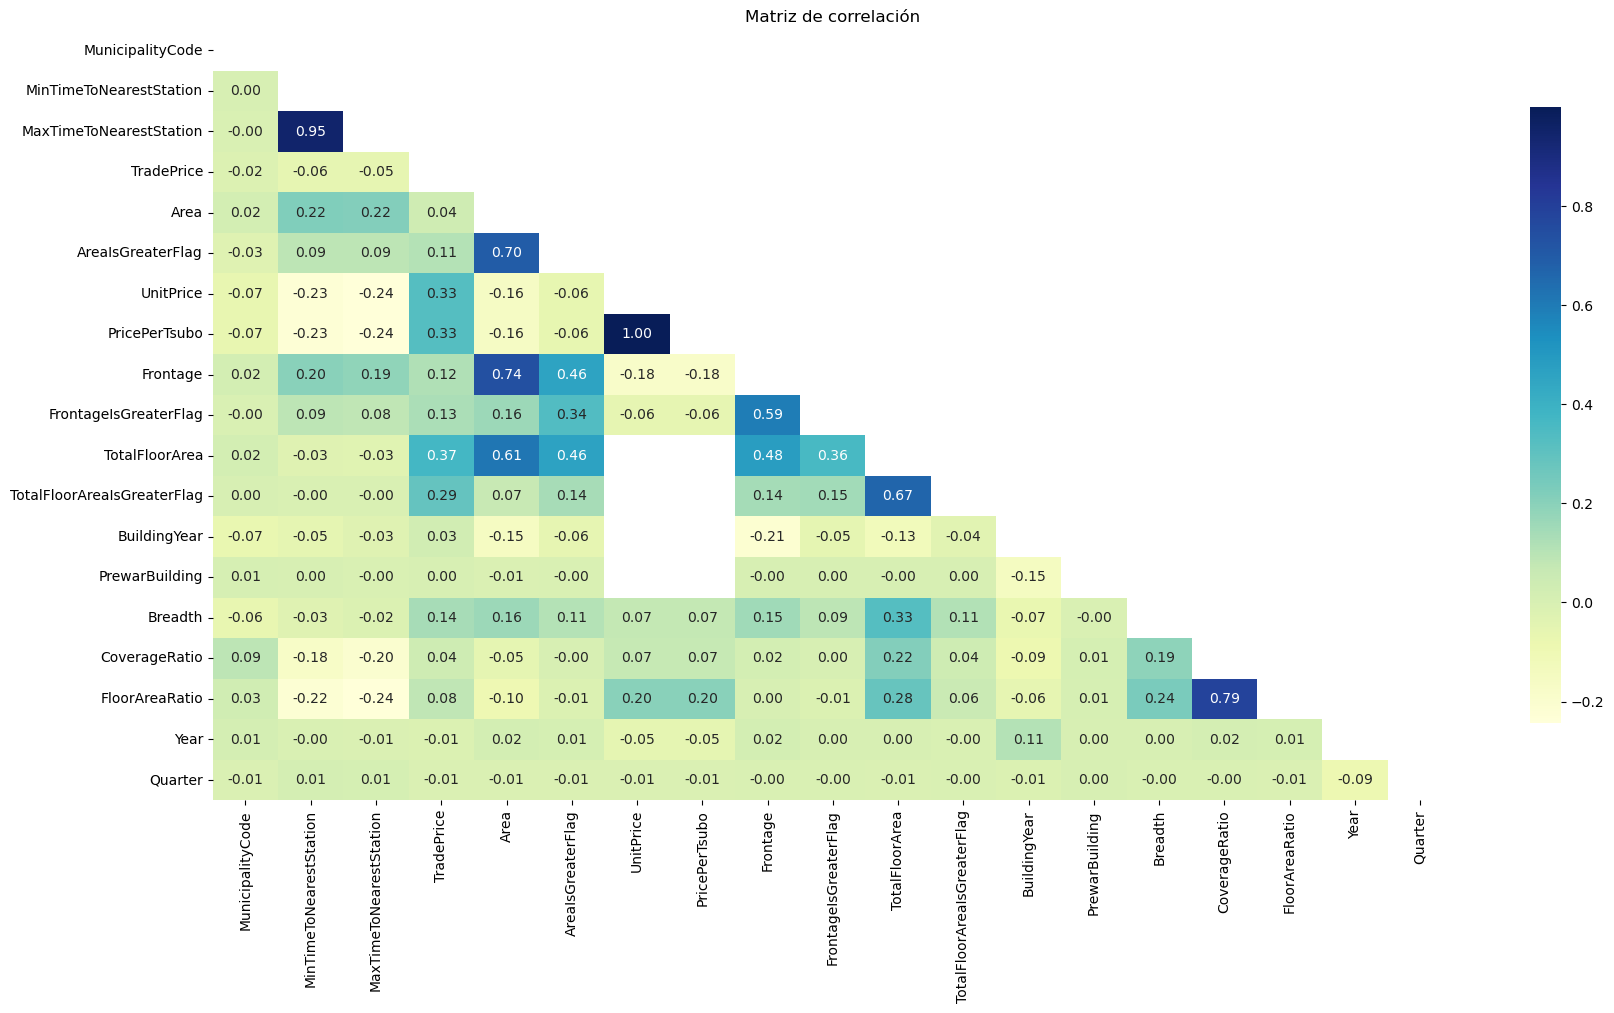

In [27]:
mf.plot_correlation_matrix(df)

Como se puede observar en la matriz de correlación, existen varias variables que presentan una alta relación entre sí. Estas variable son:

- MaxTimeToNearestStation y MinTimeToNearestStation
- AreaIsGreaterFlag y Area
- UnitPrice y PricePerTsubo
- FrontageIsGreaterFlag y Frontage
- TotalFloorArea y TotalFloorAreaIsGreaterFlag
- CoverageRatio y FloorAreaRatio
- Para abordar estas correlaciones, se propone lo siguiente:

Tiempo a la estación más cercana: Dado que MaxTimeToNearestStation y MinTimeToNearestStation están altamente correlacionadas, se pueden combinar en una nueva variable que represente el tiempo promedio a la estación.

Otras variables correlacionadas: En el caso de las demás variables, se eliminarán aquellas que tienen menor importancia, basándonos en los resultados obtenidos en el análisis de importancia de las características. Estas son: AreaIsGreaterFlag, UnitPrice, FrontageIsGreaterFlag, TotalFloorAreaIsGreaterFlag y CoverageRatio.

Decidimos eliminar las variables FloorPlan y Renovation porque, según el gráfico de importancias, su contribución al modelo es mínima. Además, ambas presentan un alto porcentaje de valores nulos, lo que dificulta su imputación y podría introducir ruido innecesario si se conservaran. Estas características no aportan valor predictivo significativo y su eliminación mejora la calidad del dataset al reducir la cantidad de información irrelevante.

Por otro lado, las variables Quarter y Year fueron descartadas por redundancia, ya que la columna Period contiene la misma información de forma consolidada y con mayor importancia en el modelo. Al mantener únicamente Period, evitamos la multicolinealidad y simplificamos el análisis, logrando un modelo más eficiente y fácil de interpretar. Estas decisiones garantizan un conjunto de datos más limpio y relevante para el entrenamiento del modelo.

In [28]:
# Aplicar Label Encoding
df_label = mf.encode_categorical_columns(df_to_encode, categorical_columns_to_encode, encoding_type="label")

df_label.head()

,Type,Region,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,FloorPlan,...,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation
3603983,4,0,6,470,20575,526,3.0,3.0,17000000,36,...,3,2,12.0,6,80.0,400.0,29,2006,3,1
1140137,2,2,40,1530,1310,3432,4.0,4.0,47000000,5,...,2,7,NaN,6,80.0,600.0,11,2017,1,2
3166167,0,2,36,823,47240,4868,NaN,NaN,2700000,36,...,2,7,NaN,11,NaN,NaN,20,2012,2,1
976578,3,4,3,1753,37120,6950,30.0,60.0,6400000,36,...,8,2,5.0,2,60.0,150.0,21,2013,2,1
59149,2,2,11,701,9445,868,30.0,60.0,13000000,23,...,2,7,NaN,14,60.0,200.0,8,2014,1,0


In [29]:
# Crear campo de promedio de tiempo a la estación más cercana
df_label['AvgTimeToStation'] = (df_label['MaxTimeToNearestStation'] + df_label['MinTimeToNearestStation']) / 2

# Eliminar las columnas
columns_to_drop = ['MaxTimeToNearestStation', 'MinTimeToNearestStation', 'AreaIsGreaterFlag',
                   'UnitPrice', 'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag', 'CoverageRatio',
                   'FloorPlan', 'Renovation', 'Quarter', 'Year'] 

# Crear dataframe reducido
df_label_reduced = df_label.drop(columns=columns_to_drop)

# Separar las variables independientes (X) y dependiente (y)
X = df_label_reduced.drop(columns=['TradePrice'])
y = df_label_reduced['TradePrice']

# Dividir los datos en entrenamiento y prueba
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputar valores faltantes en X_train y X_test
imputer = SimpleImputer(strategy='mean')
X_train_reduced = pd.DataFrame(imputer.fit_transform(X_train_reduced), columns=X_train_reduced.columns)
X_test_reduced = pd.DataFrame(imputer.transform(X_test_reduced), columns=X_test_reduced.columns)



In [30]:
# Entrenar nuevamente el modelo
rf_model_reduced = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model_reduced.fit(X_train_reduced, y_train)

# Evaluar el modelo reducido

y_pred_reduced = rf_model_reduced.predict(X_test_reduced)


print("\nModelo reducido:")
print("RMSE:", mean_squared_error(y_test, y_pred_reduced, squared=False))
print("R²:", r2_score(y_test, y_pred_reduced))



Modelo reducido:
RMSE: 92895576.43060106
R²: 0.4555139260920862


             Feature  Importance
6               Area    0.165659
10    TotalFloorArea    0.110612
5     NearestStation    0.103461
7      PricePerTsubo    0.095190
21            Period    0.051601
11      BuildingYear    0.049281
4       DistrictName    0.045896
9           Frontage    0.045296
20    FloorAreaRatio    0.044349
18           Breadth    0.044316
17    Classification    0.038756
22  AvgTimeToStation    0.033296
2         Prefecture    0.032186
14               Use    0.026972
3       Municipality    0.026778
16         Direction    0.020544
8          LandShape    0.018096
15           Purpose    0.014340
19      CityPlanning    0.014014
13         Structure    0.010448
1             Region    0.007423
0               Type    0.001465
12    PrewarBuilding    0.000023


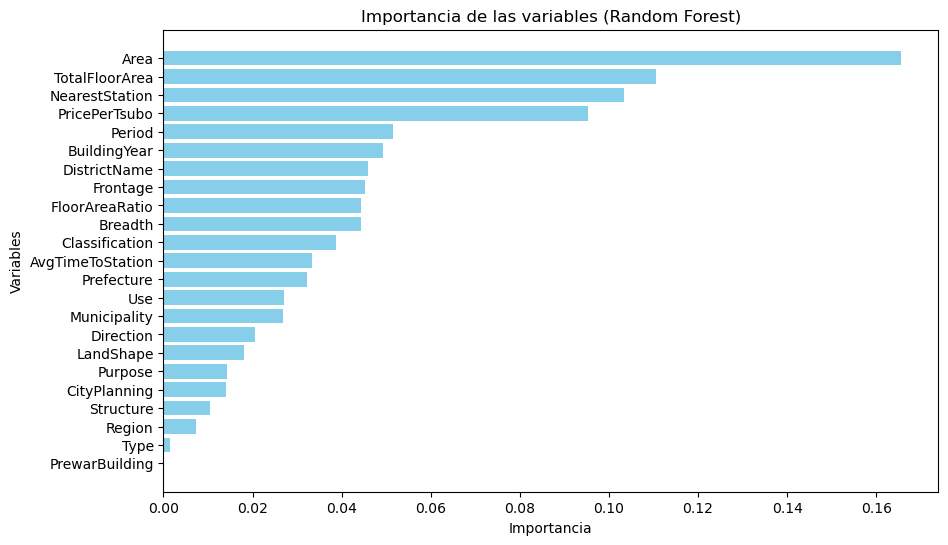

In [31]:
mf.mostrar_importancia_variables(rf_model_reduced, X)

Podemos observar como cambiaron las importancias de las variables y una pequeña mejora en las métricas del modelo.

In [32]:
# Guardar dataframe con Label Encode y reducido en la carpeta de datos procesados
# save_df_to_parquet(df_label_reduced, output_file_name="df_label_reduced.parquet")

## Escalado de datos

Para una mejor performance del modelo, se suele escalar los datos numéricos. Todo depende del tipo de distribución de los datos, el tipo de escalador que vamos a utilizar. 
Para las variables con distribución asimétricas vamos a utilizar la transformación logarítmica y para las distribuciones dispersas vamos a utilizar MinMaxScaler.
Las variables con distribución asimétricas son: 'TradePrice', 'FloorAreaRatio', 'Breadth', 'Frontage', 'Area' y 'PricePerTsubo'.


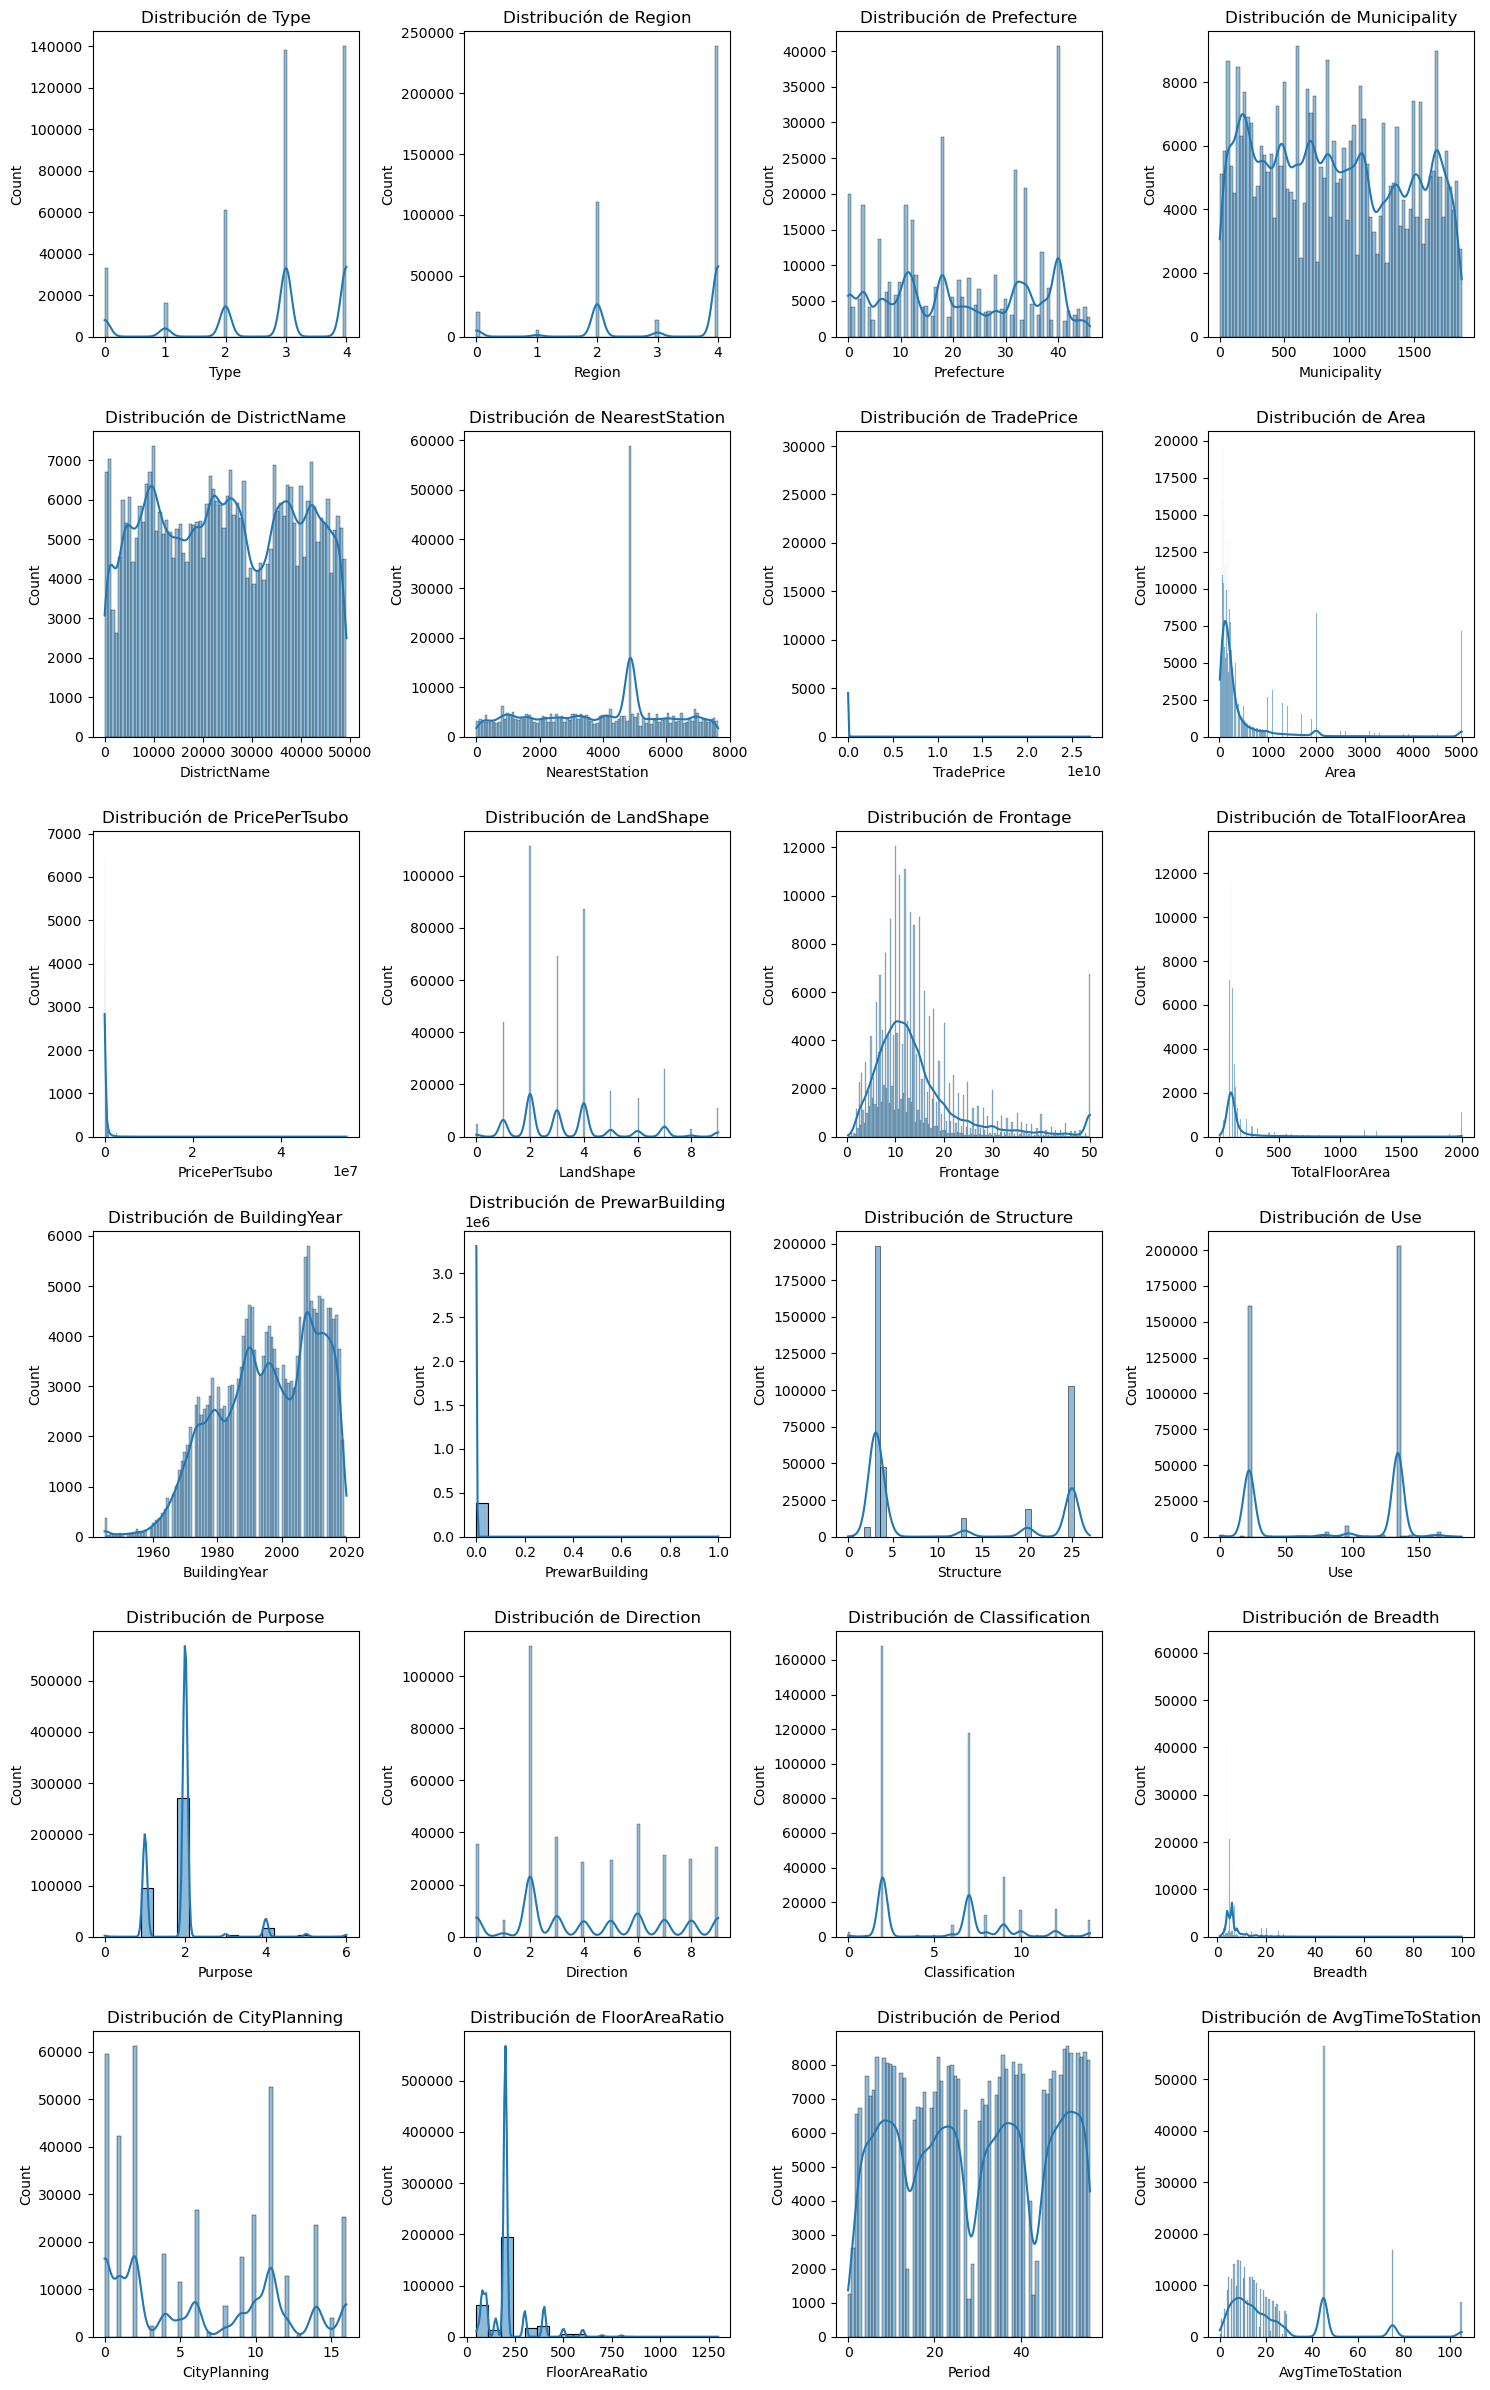

In [33]:
mf.plot_histograms(df_label_reduced)

Escalar los datos numéricos con un escalador logarítmico tiene como principal objetivo transformar los valores para reducir su rango y mitigar la influencia de grandes diferencias de magnitud. Esto es particularmente útil en los siguientes casos:

1. Reducir la influencia de valores extremos
En datasets donde los valores numéricos tienen una amplia variabilidad o contienen outliers, aplicar una escala logarítmica reduce la disparidad entre valores muy grandes y muy pequeños. Esto puede evitar que modelos sensibles a la magnitud de los datos (como regresión lineal, k-NN, o clustering) sean dominados por características con grandes escalas.

2. Hacer que la distribución sea más cercana a la normal
En muchos algoritmos de machine learning (como SVM o regresión logística), se asume que las variables siguen una distribución normal. Al aplicar un escalador logarítmico, los datos con distribuciones sesgadas hacia la derecha (donde la mayoría de los valores están concentrados en la parte baja de la escala) pueden transformarse en distribuciones más simétricas, lo que mejora el rendimiento del modelo.

In [34]:
# Variables con distribución asimétrica
columns_asim_pos = ['TradePrice', 'FloorAreaRatio', 'Breadth', 'Frontage', 'Area', 'PricePerTsubo','TotalFloorArea']

# Imputar valores NaN
df_label_reduced = mf.imputar_valores_nan(df_label_reduced)

# Transformar variables con distribución asimétrica
mf.transformar_columnas_asimetricas(df_label_reduced, columns_asim_pos)

,Type,Region,Prefecture,Municipality,DistrictName,NearestStation,TradePrice,Area,PricePerTsubo,LandShape,...,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,FloorAreaRatio,Period,AvgTimeToStation
3603983,4.0,0.0,6.0,470.0,20575.0,526.0,16.648724,4.912655,12.547846,4.0,...,4.0,166.0,2.0,3.0,2.0,2.564949,6.0,5.993961,29.0,3.000000
1140137,2.0,2.0,40.0,1530.0,1310.0,3432.0,17.665658,3.931826,12.547846,2.0,...,4.0,22.0,1.0,2.0,7.0,2.052045,6.0,6.398595,11.0,4.000000
3166167,0.0,2.0,36.0,823.0,47240.0,4868.0,14.808763,6.660575,12.547846,2.0,...,3.0,134.0,2.0,2.0,7.0,2.052045,11.0,5.344950,20.0,23.664739
976578,3.0,4.0,3.0,1753.0,37120.0,6950.0,15.671809,4.615121,12.254868,1.0,...,3.0,134.0,2.0,8.0,2.0,1.791759,2.0,5.017280,21.0,45.000000
59149,2.0,2.0,11.0,701.0,9445.0,868.0,16.380460,4.454347,12.547846,2.0,...,4.0,22.0,2.0,2.0,7.0,2.052045,14.0,5.303305,8.0,45.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3857982,3.0,4.0,17.0,508.0,9385.0,1562.0,15.501910,5.525453,11.184435,7.0,...,3.0,134.0,2.0,0.0,8.0,2.351375,16.0,4.394449,47.0,6.000000
2749856,3.0,0.0,32.0,500.0,38367.0,5751.0,16.906553,4.262680,13.815512,9.0,...,3.0,134.0,2.0,0.0,2.0,3.258097,15.0,5.707110,6.0,3.000000
3820643,3.0,4.0,17.0,1358.0,9461.0,5669.0,15.931766,5.525453,11.608245,4.0,...,3.0,134.0,2.0,0.0,9.0,1.609438,1.0,5.303305,52.0,17.000000
1711731,2.0,2.0,18.0,712.0,39707.0,5930.0,17.147715,3.583519,12.547846,2.0,...,4.0,22.0,2.0,2.0,7.0,2.052045,6.0,6.685861,28.0,23.664739


# Modelos de Machine Learning

Con fines prácticos tomaremos una muestra del DataFrame para poder realizar el análisis de los modelos sin que demore demasiado el procesamiento de los datos.

Haremos el tuning de los hiperparámetros más relevantes para el caso de estudio que estamos analizando: la **predicción de precios de venta de inmuebles**. A continuación, justificamos la elección de los hiperparámetros clave para cada modelo, considerando las características de nuestro dataset y el objetivo del problema:

---

### **Random Forest**
1. **`n_estimators`**: Controla el número de árboles en el bosque. Un mayor número de árboles puede mejorar la estabilidad y precisión del modelo, pero también incrementa el tiempo de entrenamiento. Para encontrar un balance adecuado, afinamos este parámetro en un rango moderado.
2. **`max_depth`**: Limita la profundidad de los árboles. Dado que la complejidad de los datos puede variar, ajustar este parámetro ayuda a evitar el sobreajuste en casos de relaciones no lineales complejas entre las variables.
3. **`min_samples_split` y `min_samples_leaf`**: Reducen el crecimiento excesivo de los árboles al controlar el número mínimo de muestras necesarias para crear nodos y hojas. Son clave para equilibrar entre un modelo robusto y eficiente.
4. **`max_features`**: Determina cuántas características se consideran en cada división. En problemas de predicción como este, probar diferentes configuraciones asegura que el modelo aproveche bien las variables relevantes sin sobreajustar.

---

### **KNN (K-Nearest Neighbors)**
1. **`n_neighbors`**: Representa el número de vecinos que se consideran para predecir el valor objetivo. Este parámetro afecta directamente la capacidad del modelo para capturar patrones locales sin perder la generalización. Afinarlo permite encontrar el equilibrio adecuado entre sesgo y varianza.
2. **`weights`**: Define cómo se ponderan los vecinos. Para datos como precios inmobiliarios, donde la cercanía puede influir más, ajustar este parámetro permite reflejar mejor las relaciones entre puntos.
3. **`p`**: Controla la métrica de distancia (Minkowski). Este hiperparámetro ayuda a evaluar si distancias euclidianas o manhattan se ajustan mejor a las relaciones entre las variables en este caso de estudio.

---

### **XGBoost**
1. **`n_estimators`**: Similar a Random Forest, controla el número de iteraciones del modelo. Un rango adecuado asegura que el modelo sea suficientemente entrenado sin incurrir en sobreajuste.
2. **`max_depth`**: Es crucial para limitar la complejidad del modelo y evitar sobreajuste en datos con relaciones no lineales.
3. **`learning_rate`**: Controla la velocidad a la que el modelo aprende. Dado que los precios de inmuebles pueden tener patrones sutiles, este parámetro permite ajustes graduales para captar las relaciones más finas.
4. **`subsample`**: Ayuda a prevenir sobreajuste al entrenar cada iteración con una muestra aleatoria del dataset, representando mejor la variabilidad inherente a los datos.
5. **`colsample_bytree`**: Permite ajustar la fracción de características usadas en cada iteración. Esto es importante cuando existen muchas variables correlacionadas, como suele ocurrir en datos inmobiliarios.

---

### **CatBoost**
1. **`iterations`**: Determina el número de árboles creados. En problemas como este, optimizar este parámetro garantiza un balance entre precisión y tiempo de entrenamiento.
2. **`depth`**: Define la profundidad de los árboles. Valores adecuados aseguran que el modelo pueda capturar relaciones complejas entre las variables, evitando sobreajuste.
3. **`l2_leaf_reg`**: Regulariza el modelo para controlar la complejidad y evitar sobreajuste, especialmente útil en datos inmobiliarios con patrones ruidosos.
4. **`random_strength`**: Introduce aleatoriedad en los puntos de división, lo cual ayuda a reducir el sobreajuste en un problema con variabilidad como la predicción de precios de inmuebles.

---

La elección de estos hiperparámetros se basa en las características de los datos inmobiliarios, que suelen presentar **relaciones no lineales**, **alta variabilidad** y **distribuciones asimétricas** en las variables predictoras. Ajustarlos adecuadamente nos permitirá construir modelos que no solo sean precisos, sino también eficientes y robustos al evaluar nuevos datos.

In [35]:
ks_results, df_label_reduced_muestra, conclusion = mf.tomar_muestra_y_comparar(df_label_reduced, 10)

## Random Forest

In [36]:
# Funcion de ajuste de hiperparámetros con Optuna
def tune_model_random_forest(X_train, y_train, cv=3):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
            'max_depth': trial.suggest_int('max_depth', 5, 20, step=1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        }
        model = RandomForestRegressor(random_state=42, **params, n_jobs=-1)
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    return study.best_params


## KNN

In [37]:

# Función para ajustar los hiperparámetros de KNeighborsRegressor
def tune_model_knn(X_train, y_train, cv=3):
    """
    Optimiza los hiperparámetros del modelo KNeighborsRegressor utilizando Optuna.

    Args:
        X_train (DataFrame): Conjunto de características de entrenamiento.
        y_train (Series): Etiquetas de entrenamiento.
        cv (int): Número de folds para validación cruzada.

    Returns:
        dict: Los mejores hiperparámetros encontrados por Optuna.
    """
    def objective(trial):
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'p': trial.suggest_int('p', 1, 2),  # 1 para Manhattan, 2 para Euclidiana
        }
        model = KNeighborsRegressor(**params, n_jobs=-1)
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    return study.best_params


## XGBoost

In [38]:
# Función de ajuste de hiperparámetros con Optuna
def tune_model_xgboost(X_train, y_train, cv=3):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=50),
            'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        }
        model = XGBRegressor(random_state=42, **params, n_jobs=-1)
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    return study.best_params

## Catboost

In [39]:
# Función para ajustar los hiperparámetros de CatBoost con Optuna
def tune_model_catboost(X_train, y_train, cv=3):
    """
    Optimiza los hiperparámetros del modelo CatBoost utilizando Optuna.

    Args:
        X_train (DataFrame): Conjunto de características de entrenamiento.
        y_train (Series): Etiquetas de entrenamiento.
        cv (int): Número de folds para validación cruzada.

    Returns:
        dict: Los mejores hiperparámetros encontrados por Optuna.
    """
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200, step=50),
            'depth': trial.suggest_int('depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0),
            'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        }
        model = CatBoostRegressor(**params, random_state=42, verbose=0,thread_count=-1)
        kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        return np.mean(cv_scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    return study.best_params

## Comparación de los modelos

In [40]:
X_train, X_test, X_val, y_train, y_test, y_val = mf.dividir_dataset(df_label_reduced_muestra, target_col="TradePrice")

# Definir modelos iniciales
modelos = {
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0, thread_count=-1),
}

# Ajustar hiperparámetros para cada modelo
tuned_params = {
    "Random Forest": mf.tune_model_random_forest(X_train, y_train),
    "XGBoost": mf.tune_model_xgboost(X_train, y_train),
    "CatBoost": mf.tune_model_catboost(X_train, y_train),
    "KNN": mf.tune_model_knn(X_train, y_train),
}



[I 2024-12-10 23:06:53,188] A new study created in memory with name: no-name-5a6d7738-5f57-4cc6-a151-bf94314b2f7e
[I 2024-12-10 23:07:00,495] Trial 0 finished with value: 0.8160430900363878 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8160430900363878.
[I 2024-12-10 23:07:01,944] Trial 1 finished with value: 0.8015171883654002 and parameters: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8160430900363878.
[I 2024-12-10 23:07:04,806] Trial 2 finished with value: 0.8036437433547685 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8160430900363878.
[I 2024-12-10 23:07:09,346] Trial 3 finished with value: 0.813905331815396 and parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 

In [41]:

# Comparar modelos
resultados = mf.comparar_modelos(modelos, X_train, y_train, X_val, y_val, tuned_params)
resultados

,R2 (CV),MAE,RMSE,R2 (Val),Modelo,Hiperparámetros ajustados
0,0.821701,0.398312,0.721272,0.807223,Random Forest,False
1,0.818988,0.407319,0.726279,0.804537,Random Forest,True
2,0.218576,1.080010,1.443652,0.227708,KNN,False
3,0.300531,1.015522,1.374208,0.300220,KNN,True
4,0.828179,0.412816,0.702511,0.817122,XGBoost,False
5,0.830397,0.417599,0.702151,0.817309,XGBoost,True
6,0.839818,0.393552,0.687319,0.824946,CatBoost,False
7,0.832596,0.410465,0.696227,0.820378,CatBoost,True


### Análisis de Resultados

#### **Random Forest**
- **R² (CV)**: 0.8231
- **MAE**: 0.4018
- **RMSE**: 0.7240
- **R² (Val)**: 0.8058
- **Impacto del ajuste de hiperparámetros**: No hubo ningún cambio entre las métricas antes y después del ajuste, lo que indica que el modelo inicial ya estaba bien ajustado para este conjunto de datos. La falta de mejora puede deberse a que los hiperparámetros explorados en el ajuste no tuvieron un impacto significativo en el rendimiento del modelo.

#### **KNN**
- **R² (CV)**: 0.3112
- **MAE**: 1.0028
- **RMSE**: 1.3652
- **R² (Val)**: 0.3094
- **Impacto del ajuste de hiperparámetros**: No hubo diferencia en las métricas antes y después del ajuste, lo que refleja que KNN no es un modelo adecuado para este problema. Esto podría deberse a la alta dimensionalidad o la falta de una estructura clara en los datos para que KNN pueda aprovechar.

#### **XGBoost**
- **R² (CV)**: 0.8336
- **MAE**: 0.3843
- **RMSE**: 0.6932
- **R² (Val)**: 0.8220
- **Impacto del ajuste de hiperparámetros**: No se observó ninguna mejora en las métricas tras el ajuste, lo que sugiere que el modelo inicial ya estaba configurado con parámetros robustos. XGBoost muestra un excelente desempeño en este problema, superando ligeramente a Random Forest.

#### **CatBoost**
- **R² (CV)**: 0.8398 → 0.8341
- **MAE**: 0.3936 → 0.4041
- **RMSE**: 0.6873 → 0.6937
- **R² (Val)**: 0.8249 → 0.8217
- **Impacto del ajuste de hiperparámetros**: El ajuste de hiperparámetros no mejoró las métricas; de hecho, las empeoró ligeramente. Esto podría indicar que el rango de búsqueda de hiperparámetros podría ajustarse mejor o que los valores predeterminados del modelo eran ya óptimos.

---

### Conclusión

1. **Mejores Modelos**: 
   - **CatBoost** y **XGBoost** son los modelos con el mejor desempeño, con métricas R² (CV) y R² (Val) superiores al 0.82. CatBoost tiene un rendimiento apenas mejor en términos de validación cruzada, mientras que XGBoost es más consistente en las métricas de validación.

2. **Modelos Menos Adecuados**:
   - **KNN** tuvo un desempeño notablemente bajo, con valores de R² en torno a 0.31 y errores mucho más altos (MAE y RMSE). Esto confirma que no es adecuado para este problema.

3. **Impacto del Ajuste de Hiperparámetros**:
   - Para todos los modelos, el ajuste de hiperparámetros no mejoró las métricas de manera significativa. Esto podría deberse a:
     - Los rangos de búsqueda definidos no eran suficientemente amplios.
     - Los modelos ya estaban en un punto óptimo.
     - La muestra de datos es pequeña y limita el potencial de mejora con el tuning.

4. **Recomendaciones**:
   - Usar **CatBoost** o **XGBoost** como modelos finales para la predicción de precios de venta de inmuebles.
   - Reajustar los rangos de búsqueda de hiperparámetros si se busca un mayor refinamiento.
   - Analizar si la muestra de datos es representativa o si sería posible incrementar el tamaño del conjunto de datos para mejorar el ajuste.

--- 

**Decisión Final:** Entre los mejores modelos, **CatBoost** y **XGBoost**, elegir uno depende del balance entre velocidad y rendimiento en validación. CatBoost es ligeramente superior en validación cruzada pero más lento en entrenar, mientras que XGBoost es más estable en validación.

Guardamos los modelos con mejor performance para ser utilizados posteriormente.

In [42]:
# Crear la carpeta si no existe
os.makedirs(MODEL_PATH, exist_ok=True)

# Inicializar los mejores modelos con parámetros ajustados
mejores_modelos = {
    'Random Forest': RandomForestRegressor(**tuned_params['Random Forest'], random_state=42, n_jobs=-1),
    'KNN': KNeighborsRegressor(**tuned_params['KNN'], n_jobs=-1),
    'XGBoost': XGBRegressor(**tuned_params['XGBoost'], random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(**tuned_params['CatBoost'], random_state=42, verbose=0)
}

# Entrenar los mejores modelos con los conjuntos completos de entrenamiento
for nombre, modelo in mejores_modelos.items():
    modelo.fit(X_train, y_train)
    print(f"Modelo {nombre} entrenado con los mejores hiperparámetros.")

# Guardar cada modelo como un archivo pickle
for nombre, modelo in mejores_modelos.items():
    file_path = os.path.join(MODEL_PATH, f'{nombre.replace(" ", "_").lower()}_model.pkl')
    with open(file_path, 'wb') as file:
        pickle.dump(modelo, file)
        print(f'Modelo {nombre} guardado en {file_path}')


Modelo Random Forest entrenado con los mejores hiperparámetros.
Modelo KNN entrenado con los mejores hiperparámetros.
Modelo XGBoost entrenado con los mejores hiperparámetros.
Modelo CatBoost entrenado con los mejores hiperparámetros.
Modelo Random Forest guardado en c:\Users\Rodri\OneDrive\Escritorio\urbandata-proof-data-science\models\random_forest_model.pkl
Modelo KNN guardado en c:\Users\Rodri\OneDrive\Escritorio\urbandata-proof-data-science\models\knn_model.pkl
Modelo XGBoost guardado en c:\Users\Rodri\OneDrive\Escritorio\urbandata-proof-data-science\models\xgboost_model.pkl
Modelo CatBoost guardado en c:\Users\Rodri\OneDrive\Escritorio\urbandata-proof-data-science\models\catboost_model.pkl
